1) Esta célula inicial prepara nosso ambiente de trabalho. Ela importa as bibliotecas fundamentais que usaremos para manipular dados (pandas), realizar cálculos (numpy), criar gráficos (matplotlib) e analisar redes (networkx). Além disso, ajustamos a configuração para garantir que todas as colunas dos nossos dados sejam sempre visíveis e, por fim, criamos automaticamente uma pasta chamada outputs para salvar os resultados do nosso trabalho de forma organizada.

In [3]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Mostrar todas as colunas em prints
pd.set_option("display.max_columns", None)

# Saída padrão (Colab usa /content; local usa ./outputs)
OUTPUT_DIR = "/content/outputs" if os.path.exists("/content") else "./outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Output dir:", OUTPUT_DIR)


Output dir: /content/outputs


2) Upa os arquivos necessários para o nosso trabalho.

In [4]:
from google.colab import files

# abre a janela para escolher arquivos no seu computador
uploaded = files.upload()


Saving discentes-2024.csv to discentes-2024.csv
Saving turmas-2024-2.csv to turmas-2024-2.csv
Saving cursos-ufrn.csv to cursos-ufrn.csv
Saving estruturas-curriculares.csv to estruturas-curriculares.csv
Saving cursos-de-graduacao.csv to cursos-de-graduacao.csv
Saving situacoes-discentes-2024.2.csv to situacoes-discentes-2024.2.csv
Saving matriculas-2024.2.csv to matriculas-2024.2.csv


3) Usamos a biblioteca pandas para ler cada um dos arquivos .csv (como matrículas, situações dos discentes, estruturas curriculares, etc.) e carregá-los em estruturas de tabelas, para manipulá-los.

In [5]:
import pandas as pd

df_matriculas = pd.read_csv("matriculas-2024.2.csv", sep=";")
df_discentes_situacoes = pd.read_csv("situacoes-discentes-2024.2.csv", sep=";")
df_estruturas = pd.read_csv("estruturas-curriculares.csv", sep=";")
df_cursos_grad = pd.read_csv("cursos-de-graduacao.csv", sep=";")
df_cursos_ufrn = pd.read_csv("cursos-ufrn.csv", sep=";")
df_discentes = pd.read_csv("discentes-2024.csv", sep=";")
df_turmas = pd.read_csv("turmas-2024-2.csv", sep=";")


4) Esta célula executa uma leitura inteligente e organizada dos arquivos CSV que foram carregados na etapa anterior.

In [6]:
# === ETAPA 2 — Leitura dos 7 CSVs (pós-upload no Colab) ===
import os
import pandas as pd

# Se você acabou de rodar `files.upload()`, os arquivos estão em /content (Colab)
BASE = "/content" if os.path.exists("/content") else "."

# Nomes exatamente como apareceram no upload
FILES = {
    "matriculas"            : "matriculas-2024.2.csv",
    "discentes_situacoes"   : "situacoes-discentes-2024.2.csv",
    "estruturas"            : "estruturas-curriculares.csv",
    "cursos_grad"           : "cursos-de-graduacao.csv",
    "cursos_ufrn"           : "cursos-ufrn.csv",
    "discentes"             : "discentes-2024.csv",
    "turmas"                : "turmas-2024-2.csv",
}

def read_csv_smart(filename, base=BASE):
    """Tenta ler com ';' (padrão UFRN) e cai para ',' se precisar."""
    path = os.path.join(base, filename)
    try:
        return pd.read_csv(path, sep=";")
    except Exception:
        return pd.read_csv(path)

# Lê todos
df_matriculas          = read_csv_smart(FILES["matriculas"])
df_discentes_situacoes = read_csv_smart(FILES["discentes_situacoes"])
df_estruturas          = read_csv_smart(FILES["estruturas"])
df_cursos_grad         = read_csv_smart(FILES["cursos_grad"])
df_cursos_ufrn         = read_csv_smart(FILES["cursos_ufrn"])
df_discentes           = read_csv_smart(FILES["discentes"])
df_turmas              = read_csv_smart(FILES["turmas"])

# Escolhe a tabela de cursos a usar (evita erro do "or" com DataFrame)
def pick_df(*cands):
    for d in cands:
        if d is not None and not d.empty:
            return d
    return None

df_cursos = pick_df(df_cursos_grad, df_cursos_ufrn)

# Checagens rápidas
print("matriculas           :", df_matriculas.shape)
print("discentes_situacoes  :", df_discentes_situacoes.shape)
print("estruturas           :", df_estruturas.shape)
print("cursos_grad          :", df_cursos_grad.shape)
print("cursos_ufrn          :", df_cursos_ufrn.shape)
print("=> df_cursos (escolhido):", None if df_cursos is None else df_cursos.shape)
print("discentes            :", df_discentes.shape)
print("turmas              :", df_turmas.shape)

# (Opcional) olhadinha nas primeiras linhas
# display(df_matriculas.head(3))
# display(df_turmas.head(3))
# display(df_cursos.head(3))

matriculas           : (655943, 10)
discentes_situacoes  : (33763, 10)
estruturas           : (450, 28)
cursos_grad          : (126, 22)
cursos_ufrn          : (1460, 22)
=> df_cursos (escolhido): (126, 22)
discentes            : (14458, 17)
turmas              : (14721, 26)


5) Esta célula verifica e prepara as tabelas de matrículas e turmas, limpando os dados, identificando reprovações e padronizando os nomes das colunas para a análise.

In [7]:
assert df_matriculas is not None, "Preciso do arquivo 'matriculas-2024.2.csv'"
assert df_turmas is not None, "Preciso do arquivo 'turmas-2024-2.csv'"

# Matrículas: normalizar situação e criar flag de reprovação
df_m = df_matriculas.copy()
df_m["descricao_norm"] = df_m["descricao"].astype(str).str.upper().str.strip()
df_m["reprovado"] = df_m["descricao_norm"].str.contains("REPROVADO")

# Notas/médias para uso futuro
for col in ["nota", "media_final"]:
    if col in df_m.columns:
        df_m[col + "_num"] = (
            df_m[col].astype(str).str.replace(",", ".", regex=False).str.replace("%","", regex=False)
        )
        df_m[col + "_num"] = pd.to_numeric(df_m[col + "_num"], errors="coerce")

# Turmas: padronizar nomes esperados
df_t = df_turmas.copy()
rename_map = {}
for c in df_t.columns:
    cl = c.lower()
    if cl == "id_turma": rename_map[c] = "id_turma"
    if "id_componente" in cl: rename_map[c] = "id_componente_curricular"
    if "codigo_turma" in cl or ("codigo" in cl and "turma" in cl): rename_map[c] = "codigo_turma"
    if "nome_componente" in cl or ("disciplina" in cl and "nome" in cl): rename_map[c] = "nome_componente"
    if cl == "id_curso": rename_map[c] = "id_curso"
if rename_map:
    df_t.rename(columns=rename_map, inplace=True)

print("Colunas turmas (pós-normalização):", list(df_t.columns)[:15])

Colunas turmas (pós-normalização): ['id_turma', 'codigo_turma', 'siape', 'matricula_docente_externo', 'observacao', 'id_componente_curricular', 'ch_dedicada_periodo', 'nivel_ensino', 'campus_turma', 'local', 'ano', 'periodo', 'data_inicio', 'data_fim', 'descricao_horario']


6) Nesta célula, unimos os dados de matrículas e turmas para calcular as taxas de reprovação. O código então gera, exibe e salva em arquivos .csv três rankings com os maiores índices de reprovação: um geral por disciplina, outro mais específico por disciplina dentro de cada curso, e um terceiro por turma.

In [8]:

# Join matrículas ↔ turmas (para obter componente/código/curso)
keep_cols = ["id_turma","id_componente_curricular","codigo_turma"]
if "nome_componente" in df_t.columns: keep_cols.append("nome_componente")
if "id_curso" in df_t.columns: keep_cols.append("id_curso")

df_join = df_m.merge(df_t[keep_cols], on="id_turma", how="left")

# Ranking por disciplina
ranking_disc = (df_join.groupby("id_componente_curricular", as_index=False)
                .agg(matriculas=("discente","count"),
                     reprovacoes=("reprovado","sum")))
ranking_disc["taxa_reprovacao"] = (ranking_disc["reprovacoes"] / ranking_disc["matriculas"]).round(4)

if "nome_componente" in df_join.columns:
    nomes = df_join[["id_componente_curricular","nome_componente"]].dropna().drop_duplicates()
    ranking_disc = ranking_disc.merge(nomes, on="id_componente_curricular", how="left")

ranking_disc = ranking_disc.sort_values(["reprovacoes","taxa_reprovacao","matriculas"], ascending=False).reset_index(drop=True)
display(ranking_disc.head(10))

# Ranking por disciplina × curso
ranking_disc_curso = None
if "id_curso" in df_join.columns:
    ranking_disc_curso = (df_join.groupby(["id_componente_curricular","id_curso"], as_index=False)
                          .agg(matriculas=("discente","count"),
                               reprovacoes=("reprovado","sum")))
    ranking_disc_curso["taxa_reprovacao"] = (ranking_disc_curso["reprovacoes"]/ranking_disc_curso["matriculas"]).round(4)

    # Nome do curso (se disponível)
    if df_cursos_grad is not None:
        # tentar colunas de id e nome
        id_col = next((c for c in df_cursos_grad.columns if c.lower()=="id_curso" or "id_curso" in c.lower()), None)
        name_col = next((c for c in df_cursos_grad.columns if ("nome" in c.lower() and "curso" in c.lower()) or c.lower()=="curso"), None)
        if id_col and name_col:
            cursos_map = df_cursos_grad[[id_col, name_col]].drop_duplicates()
            cursos_map.columns = ["id_curso","curso_nome"]
            ranking_disc_curso = ranking_disc_curso.merge(cursos_map, on="id_curso", how="left")

    if "nome_componente" in df_join.columns:
        ranking_disc_curso = ranking_disc_curso.merge(nomes, on="id_componente_curricular", how="left")

    ranking_disc_curso = ranking_disc_curso.sort_values(["reprovacoes","taxa_reprovacao","matriculas"], ascending=False).reset_index(drop=True)
    display(ranking_disc_curso.head(10))

# Ranking por turma
ranking_turma = (df_join.groupby("id_turma", as_index=False)
                 .agg(matriculas=("discente","count"),
                      reprovacoes=("reprovado","sum")))
ranking_turma["taxa_reprovacao"] = (ranking_turma["reprovacoes"]/ranking_turma["matriculas"]).round(4)
if "codigo_turma" in df_join.columns:
    ranking_turma = ranking_turma.merge(df_join[["id_turma","codigo_turma"]].drop_duplicates(), on="id_turma", how="left")

ranking_turma = ranking_turma.sort_values(["reprovacoes","taxa_reprovacao","matriculas"], ascending=False).reset_index(drop=True)
display(ranking_turma.head(10))

# Exportar
ranking_disc.to_csv(os.path.join(OUTPUT_DIR, "ranking_disciplina.csv"), index=False, encoding="utf-8")
if ranking_disc_curso is not None:
    ranking_disc_curso.to_csv(os.path.join(OUTPUT_DIR, "ranking_disciplina_curso.csv"), index=False, encoding="utf-8")
ranking_turma.to_csv(os.path.join(OUTPUT_DIR, "ranking_turma.csv"), index=False, encoding="utf-8")
print("Arquivos salvos em", OUTPUT_DIR)

,id_componente_curricular,matriculas,reprovacoes,taxa_reprovacao
0,74692,111853,2523,0.0226
1,2049855,27370,2343,0.0856
2,77487,4148,2157,0.5200
3,77497,4095,2073,0.5062
4,77491,5881,1878,0.3193
5,77483,2993,1770,0.5914
6,77512,2900,1644,0.5669
7,72252,24320,1536,0.0632
8,78870,9200,1500,0.1630
9,72280,4932,1404,0.2847


,id_componente_curricular,id_curso,matriculas,reprovacoes,taxa_reprovacao
0,74692,13027790.0,111853,2523,0.0226
1,2049855,2000039.0,27370,2343,0.0856
2,77487,10320810.0,3277,1803,0.5502
3,77497,10320810.0,3315,1752,0.5285
4,77491,10320810.0,4588,1542,0.3361
5,72252,104411100.0,24320,1536,0.0632
6,78870,170723080.0,9200,1500,0.1630
7,77483,10320810.0,2357,1488,0.6313
8,72280,1086001.0,4932,1404,0.2847
9,77512,10320810.0,1848,1272,0.6883


,id_turma,matriculas,reprovacoes,taxa_reprovacao,codigo_turma
0,57743740,111853,2523,0.0226,01
1,57749591,24320,1536,0.0632,01
2,57749609,9200,1500,0.1630,01
3,57749544,4932,1404,0.2847,01
4,57746333,3300,1200,0.3636,05
5,57744120,44795,867,0.0194,01
6,57742335,1276,780,0.6113,08
7,57742354,3100,675,0.2177,01
8,57742629,1288,672,0.5217,03
9,57746154,4032,648,0.1607,02A


Arquivos salvos em /content/outputs


7) Este código calcula a taxa de reprovação para cada curso, adiciona os nomes correspondentes para facilitar a leitura e exibe um ranking com os 20 cursos que apresentam os maiores totais de reprovação.

In [9]:
# --- normalização + flag de reprovação ---
df_m = df_matriculas.copy()
df_m["descricao_norm"] = df_m["descricao"].astype(str).str.upper().str.strip()
df_m["reprovado"] = df_m["descricao_norm"].str.contains("REPROVADO")

# --- agregação por curso ---
agg_curso = (df_m
    .groupby("id_curso", as_index=False)
    .agg(matriculas=("discente","count"),
         reprovacoes=("reprovado","sum"))
)
agg_curso["taxa_reprovacao"] = agg_curso["reprovacoes"] / agg_curso["matriculas"]

# --- nome do curso (a partir do arquivo de situações dos discentes) ---
cursos = df_discentes_situacoes[["id_curso","curso"]].drop_duplicates()
ranking_curso = (agg_curso
    .merge(cursos, on="id_curso", how="left")
    .sort_values(["reprovacoes","taxa_reprovacao","matriculas"], ascending=False)
    .reset_index(drop=True)
)

# ver top
ranking_curso.head(20)[["curso","matriculas","reprovacoes","taxa_reprovacao"]]

,curso,matriculas,reprovacoes,taxa_reprovacao
0,CIÊNCIAS E TECNOLOGIA,42570,13120,0.308198
1,TECNOLOGIA DA INFORMAÇÃO,20336,2992,0.147128
2,FARMÁCIA,34121,2078,0.060901
3,CIÊNCIAS CONTÁBEIS,10726,1844,0.171919
4,ADMINISTRAÇÃO,13907,1383,0.099446
5,CURSO TÉCNICO DA METRÓPOLE DIGITAL,5212,1316,0.252494
6,ENGENHARIA CIVIL,8355,1271,0.152124
7,TECNICO EM AGROPECUARIA SUBSEQUENTE,2766,1200,0.433839
8,ENGENHARIA ELÉTRICA,5816,1119,0.192400
9,CIÊNCIAS BIOLÓGICAS,12784,1035,0.080961


8) Visualização em 3D

In [10]:
# Grafo 3D dos cursos (Plotly) com arestas por similaridade
import numpy as np
import networkx as nx
import plotly.graph_objects as go

def plot_cursos_3d(
    ranking_curso,
    max_nodes=100,
    thr=0.05,
    criterio="taxa",        # "taxa" ou "abs"  (similaridade por taxa de reprovação ou nº absoluto de reprovações)
    show_labels=True,
    max_edges=None,         # limite opcional de arestas desenhadas (ex.: 300). None = sem limite
    seed=42
):
    """
    ranking_curso: DataFrame com colunas ['curso','reprovacoes','matriculas','taxa_reprovacao']
    thr: limiar de similaridade.
         - criterio="taxa": conecta se |taxa_i - taxa_j| < thr
         - criterio="abs" : conecta se |reprov_i - reprov_j| / max(reprov) < thr
    """
    df = ranking_curso.copy().head(max_nodes).dropna(subset=["curso"])

    if "taxa_reprovacao" not in df.columns and {"reprovacoes","matriculas"}.issubset(df.columns):
        df["taxa_reprovacao"] = df["reprovacoes"] / df["matriculas"]

    # --- monta grafo ---
    G = nx.Graph()
    for _, r in df.iterrows():
        G.add_node(
            r["curso"],
            reprovacoes=float(r["reprovacoes"]),
            taxa=float(r["taxa_reprovacao"])
        )

    # matriz para limitar arestas se necessário
    edges = []
    rmax = max(float(df["reprovacoes"].max()), 1.0)

    for i in range(len(df)):
        for j in range(i+1, len(df)):
            if criterio == "taxa":
                diff = abs(df.iloc[i]["taxa_reprovacao"] - df.iloc[j]["taxa_reprovacao"])
                ok = diff < thr
                # similaridade maior quando diff é menor
                sim = max(1.0 - (diff / thr), 0.0) if ok else 0.0
            else:  # "abs" por reprovações absolutas (normalizadas)
                diff = abs(df.iloc[i]["reprovacoes"] - df.iloc[j]["reprovacoes"]) / rmax
                ok = diff < thr
                sim = max(1.0 - (diff / thr), 0.0) if ok else 0.0

            if ok:
                edges.append((df.iloc[i]["curso"], df.iloc[j]["curso"], sim))

    # se quiser limitar o nº de arestas, pega as mais similares
    if max_edges is not None and len(edges) > max_edges:
        edges = sorted(edges, key=lambda t: t[2], reverse=True)[:max_edges]

    # adiciona arestas no grafo
    for u, v, sim in edges:
        G.add_edge(u, v, weight=sim)

    # --- layout 3D ---
    pos = nx.spring_layout(G, dim=3, seed=seed, k=0.8, weight="weight")

    # coordenadas dos nós
    Xn = [pos[n][0] for n in G.nodes()]
    Yn = [pos[n][1] for n in G.nodes()]
    Zn = [pos[n][2] for n in G.nodes()]

    # coordenadas das arestas (com largura/alpha por similaridade)
    Xe, Ye, Ze, widths, alphas = [], [], [], [], []
    for u, v, d in G.edges(data=True):
        Xe += [pos[u][0], pos[v][0], None]
        Ye += [pos[u][1], pos[v][1], None]
        Ze += [pos[u][2], pos[v][2], None]
        sim = float(d.get("weight", 0.5))
        widths.append(0.5 + 3.5*sim)        # 0.5 a 4.0
        alphas.append(0.15 + 0.55*sim)      # 0.15 a 0.70

    # tamanhos de nó (∝ reprovações)
    reprov = np.array([G.nodes[n]["reprovacoes"] for n in G.nodes()])
    sizes = np.interp(reprov, (reprov.min() if reprov.size else 0, reprov.max() if reprov.size else 1), (6, 28)) if reprov.size else []

    # cor por taxa
    taxa = np.array([G.nodes[n]["taxa"] for n in G.nodes()])
    hover = [f"{n}<br>Reprovações: {int(G.nodes[n]['reprovacoes'])}"
             f"<br>Taxa: {G.nodes[n]['taxa']:.2%}" for n in G.nodes()]

    # desenha arestas (em um trace; usa largura média e alpha médio para não sobrecarregar)
    edge_color = "rgba(100,100,100,0.35)"
    if alphas:
        # usa alpha médio para o conjunto (Plotly não aceita alpha por segmento)
        edge_alpha = np.mean(alphas)
        edge_color = f"rgba(100,100,100,{edge_alpha:.2f})"
    edge_width = float(np.mean(widths)) if widths else 1.0

    edge_trace = go.Scatter3d(
        x=Xe, y=Ye, z=Ze, mode="lines",
        line=dict(width=edge_width, color=edge_color),
        hoverinfo="none", showlegend=False
    )

    # desenha nós
    node_trace = go.Scatter3d(
        x=Xn, y=Yn, z=Zn,
        mode="markers+text" if show_labels else "markers",
        marker=dict(
            size=sizes,
            color=taxa,
            colorscale="Viridis",
            colorbar=dict(title="Taxa de reprovação"),
            opacity=0.9
        ),
        text=[n if len(n) <= 22 else n[:22]+"…" for n in G.nodes()] if show_labels else None,
        textposition="top center",
        textfont=dict(size=9),
        hovertext=hover,
        hoverinfo="text",
        showlegend=False
    )

    title_sub = "taxa semelhante" if criterio == "taxa" else "reprovações absolutas semelhantes"
    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            title=f"Grafo 3D dos Cursos (até {max_nodes}) — conexões por {title_sub} (thr={thr})",
            margin=dict(l=0, r=0, t=50, b=0),
            scene=dict(
                xaxis=dict(showbackground=False, visible=False),
                yaxis=dict(showbackground=False, visible=False),
                zaxis=dict(showbackground=False, visible=False),
            )
        )
    )
    fig.show()

# ---- usar ----
# Conectar por taxas parecidas (<= 5 p.p. de diferença)
plot_cursos_3d(ranking_curso, max_nodes=100, thr=0.05, criterio="taxa", show_labels=True, max_edges=600)

# (opcional) Conectar por nº absoluto de reprovações parecidos (normalizados)
# plot_cursos_3d(ranking_curso, max_nodes=100, thr=0.08, criterio="abs", show_labels=False, max_edges=500)


9)Visualização 2D

--- Métricas da Rede (Top 30 Cursos) ---
Número de nós (cursos): 30
Número de arestas (conexões): 122
Grau médio da rede: 8.13
Densidade da rede: 0.2805
Assortatividade da rede (grau): 0.6577


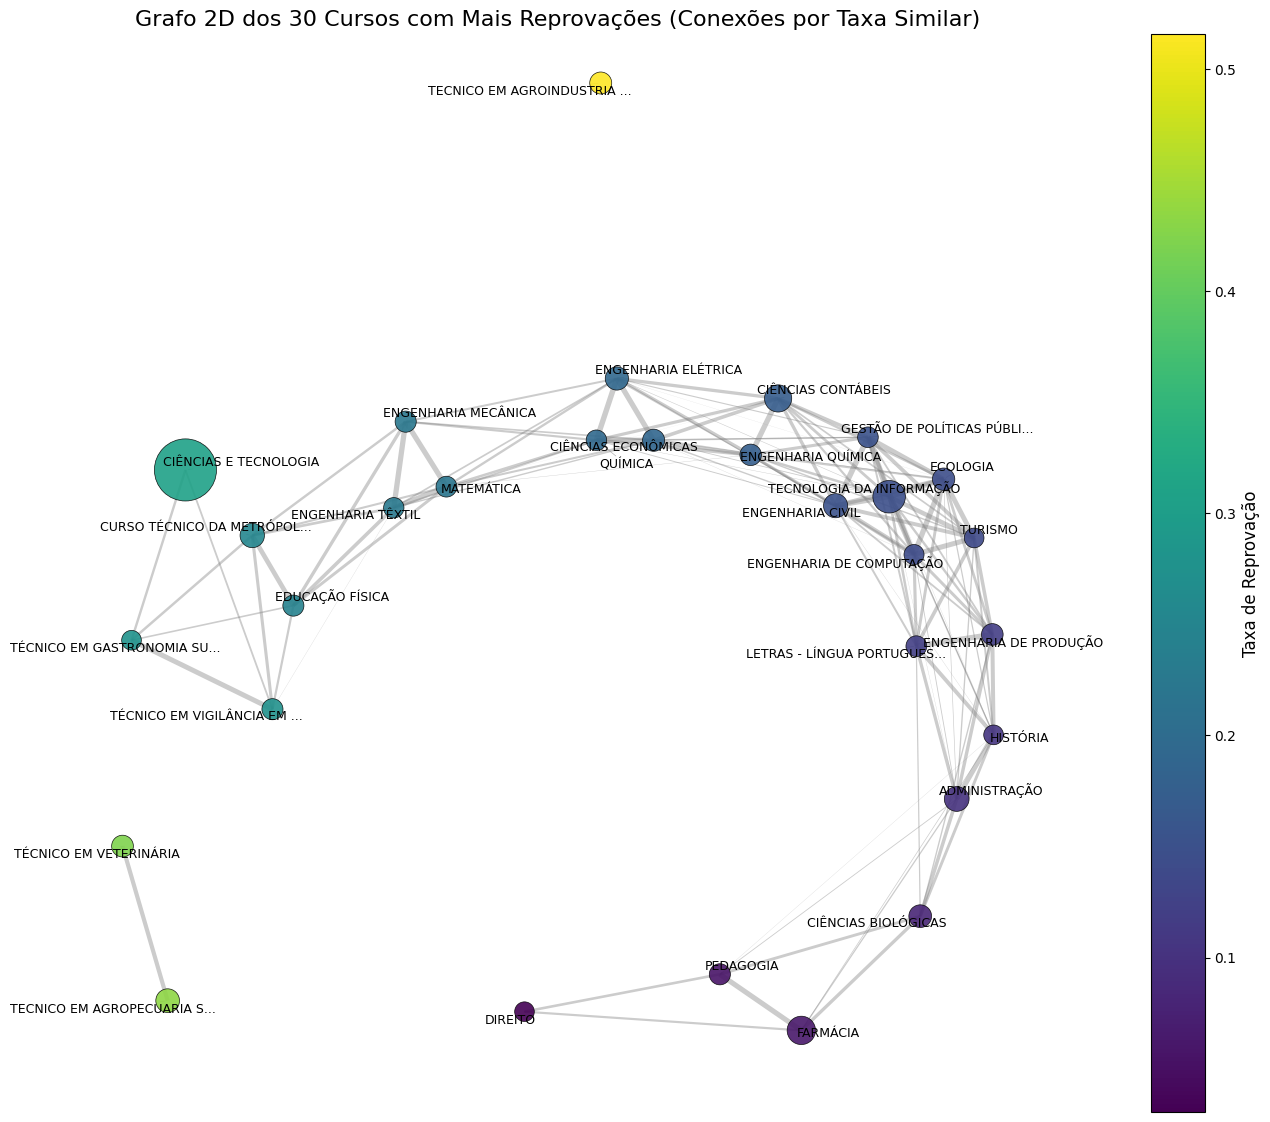

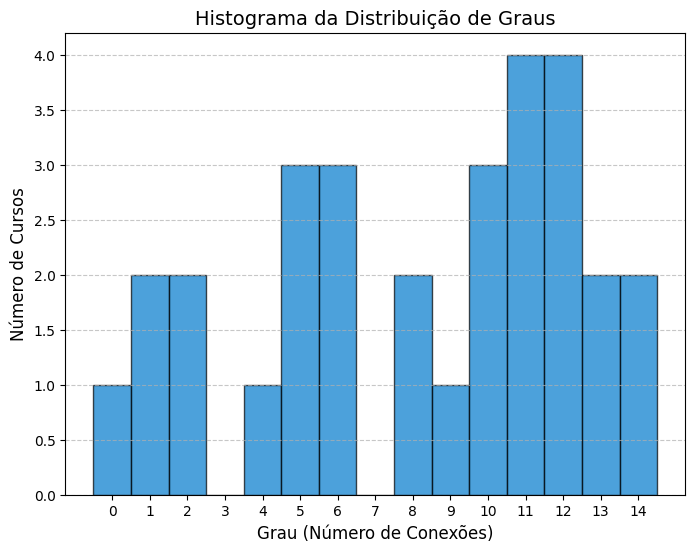

In [19]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text

def plot_cursos_2d_and_metrics_v2(
    ranking_curso,
    max_nodes=30,
    thr=0.05,
    criterio="taxa",
    seed=42
):
    df = ranking_curso.copy().head(max_nodes).dropna(subset=["curso"])

    if "taxa_reprovacao" not in df.columns and {"reprovacoes", "matriculas"}.issubset(df.columns):
        df["taxa_reprovacao"] = df["reprovacoes"] / df["matriculas"]

    # --- Monta o grafo ---
    G = nx.Graph()
    for _, r in df.iterrows():
        G.add_node(
            r["curso"],
            reprovacoes=float(r["reprovacoes"]),
            taxa=float(r["taxa_reprovacao"])
        )

    rmax = max(float(df["reprovacoes"].max()), 1.0)
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            if criterio == "taxa":
                diff = abs(df.iloc[i]["taxa_reprovacao"] - df.iloc[j]["taxa_reprovacao"])
                ok = diff < thr
                sim = max(1.0 - (diff / thr), 0.0) if ok else 0.0
            else:
                diff = abs(df.iloc[i]["reprovacoes"] - df.iloc[j]["reprovacoes"]) / rmax
                ok = diff < thr
                sim = max(1.0 - (diff / thr), 0.0) if ok else 0.0

            if ok:
                G.add_edge(df.iloc[i]["curso"], df.iloc[j]["curso"], weight=sim)

    # --- Análise de Métricas da Rede ---
    print("--- Métricas da Rede (Top 30 Cursos) ---")
    print(f"Número de nós (cursos): {G.number_of_nodes()}")
    print(f"Número de arestas (conexões): {G.number_of_edges()}")

    degrees = [d for n, d in G.degree()]
    if G.number_of_nodes() > 0 and degrees:
        print(f"Grau médio da rede: {np.mean(degrees):.2f}")
        print(f"Densidade da rede: {nx.density(G):.4f}")
        if G.number_of_nodes() > 2 and G.number_of_edges() > 0:
            print(f"Assortatividade da rede (grau): {nx.degree_assortativity_coefficient(G):.4f}")

    # --- Visualização 2D Melhorada ---
    plt.figure(figsize=(17, 14)) # Aumentei o tamanho da figura para dar mais espaço

    ########################################################################
    # AQUI ESTÁ A MUDANÇA PARA DEIXAR O GRAFO MAIS ESPALHADO
    pos = nx.spring_layout(G, seed=seed, k=1.3, iterations=150)
    ########################################################################

    # Cores e tamanhos dos nós
    node_colors = [G.nodes[n]["taxa"] for n in G.nodes()]
    reprovs = np.array([G.nodes[n]["reprovacoes"] for n in G.nodes()])
    node_sizes = np.interp(reprovs, (reprovs.min(), reprovs.max()), (200, 2000))

    # Largura das arestas baseada na similaridade (peso)
    edge_widths = [d['weight'] * 4 for u, v, d in G.edges(data=True)]

    # Desenha o grafo
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis, alpha=0.9, edgecolors='black', linewidths=0.5)
    nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.4, width=edge_widths)

    # Rótulos inteligentes com adjustText
    texts = []
    for node, (x, y) in pos.items():
        label = (node[:25] + "...") if len(node) > 25 else node
        texts.append(plt.text(x, y, label, fontsize=9, ha='center', va='center'))

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.6))

    plt.title(f"Grafo 2D dos 30 Cursos com Mais Reprovações (Conexões por Taxa Similar)", fontsize=16)
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), label="Taxa de Reprovação").set_label("Taxa de Reprovação", size=12)
    plt.axis("off")
    plt.show()

    # --- Histograma de Distribuição de Graus ---
    if degrees:
        plt.figure(figsize=(8, 6))
        plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), edgecolor="black", align="left", color='#007acc', alpha=0.7)
        plt.title("Histograma da Distribuição de Graus", fontsize=14)
        plt.xlabel("Grau (Número de Conexões)", fontsize=12)
        plt.ylabel("Número de Cursos", fontsize=12)
        plt.xticks(range(min(degrees), max(degrees) + 1))
        plt.grid(axis="y", linestyle='--', alpha=0.7)
        plt.show()


plot_cursos_2d_and_metrics_v2(ranking_curso, max_nodes=30, thr=0.05)